In [1]:
# import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score,confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import scikitplot as skplt

LOGISTIC REGRESSION ASSUMPTIONS:
- Logistic regression (LR) does not require the continuous independent variables (IV) to be linearly related to the dependent variable (DV). It does require the continuous  IV be linearly related to the log odds of the IV though. A way to test this is to plot the IV in question and look for an S-shaped curve. Sometimes the S-shape will not be obvious. The plot should have a flat or flat-ish top and bottom with an increase or decreasing middle,
- The error terms (residuals) do not need to be normally distributed,
- Homoscedasticity (error term is the same across all values of the independent variables) is not required,
- Binary LR requires the dependent variable to be binary and ordinal logistic regression requires the dependent variable to be ordinal,
- LR requires the observations to be independent of each other. In other words, the observations should not come from repeated measurements or matched data,
- It requires there to be little or no multicollinearity among the independent variables.  This means that the independent variables should not be too highly correlated with each other,
- The sample size rule of thumb is that the regression analysis requires at least 20 cases per independent variable in the analysis. 

In [2]:
# get the data
df = pd.read_csv('../input/bank-full.csv', sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
# shape, missing values and type info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
y            45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


### Label variable

In [4]:
# column 'y' is renamed
df = df.rename(columns={'y': 'response'})

In [5]:
# change values to 0 or 1
df['response'] = df['response'].apply(lambda x:0 if x=='no' else 1)  

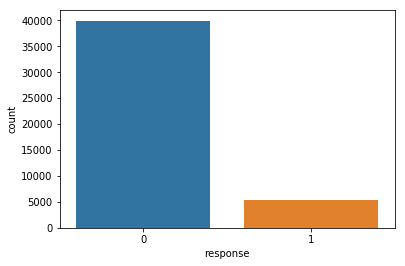

In [6]:
sns.countplot(df['response'])
plt.show()

In [7]:
df['response'].value_counts()

0    39922
1     5289
Name: response, dtype: int64

In [8]:
# undersampling 
no_df = df[df['response']==0]
yes_df = df[df['response']==1]
no_df_downsampled = resample(no_df, replace=True, n_samples=len(yes_df), random_state=4)
df = pd.concat([no_df_downsampled, yes_df], axis=0)

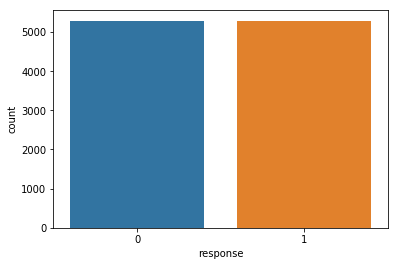

In [9]:
sns.countplot(df['response'])
plt.show()

### Categorical features

In [10]:
features = df.drop(columns='response', axis=1)
cat_cols = features.select_dtypes(include='object').columns
cat_cols

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome'],
      dtype='object')

In [11]:
# summary statistics
features[cat_cols].describe()

,job,marital,education,default,housing,loan,contact,month,poutcome
count,10578,10578,10578,10578,10578,10578,10578,10578,10578
unique,12,3,4,2,2,2,3,12,4
top,management,married,secondary,no,no,no,cellular,may,unknown
freq,2361,5958,5271,10418,5553,9184,7717,2592,7836


In [12]:
# unique values
for col in cat_cols:
    print(features[col].value_counts())
    print('-------------------------------------------------')

management       2361
blue-collar      1869
technician       1756
admin.           1251
services          905
retired           722
unemployed        381
self-employed     373
student           340
entrepreneur      293
housemaid         266
unknown            61
Name: job, dtype: int64
-------------------------------------------------
married     5958
single      3398
divorced    1222
Name: marital, dtype: int64
-------------------------------------------------
secondary    5271
tertiary     3467
primary      1382
unknown       458
Name: education, dtype: int64
-------------------------------------------------
no     10418
yes      160
Name: default, dtype: int64
-------------------------------------------------
no     5553
yes    5025
Name: housing, dtype: int64
-------------------------------------------------
no     9184
yes    1394
Name: loan, dtype: int64
-------------------------------------------------
cellular     7717
unknown      2149
telephone     712
Name: contact, dtype: 

In [13]:
# in 'default', 'housing', and 'loan': 'no' is converted to 0, and 'yes' to 1
cols_to_convert = ['default','housing','loan']
for col in cols_to_convert:    
    df[col] = df[col].apply(lambda x:0 if x=='no' else 1)    
    
df[cat_cols].head()    

,job,marital,education,default,housing,loan,contact,month,poutcome
18356,blue-collar,married,secondary,0,0,0,cellular,jul,unknown
8651,technician,single,tertiary,0,1,1,unknown,jun,unknown
28489,technician,single,secondary,0,1,0,cellular,jan,failure
12317,admin.,married,secondary,0,1,1,unknown,jun,unknown
24566,management,single,tertiary,0,1,0,cellular,nov,failure


job has 288 'unknown' values, <br>
education has 1857 'unknown' values, <br>
contact has 13020 'unknown' values, <br>
poutcome has 36959 'unknown' and 1840 'others' values. <br>

In [14]:
# since 'unknown' is an ambiguous word is replaced by 'others' in all columns.
df = df.replace(to_replace='unknown', value='others' )
# all values in 'poutcome' that are not 'failure' or 'success' are deleted.
df = df.drop(df[(df['poutcome']=='others')].index, axis=0)
df = df.reset_index(drop=True)
df[cat_cols].head()

,job,marital,education,default,housing,loan,contact,month,poutcome
0,technician,single,secondary,0,1,0,cellular,jan,failure
1,management,single,tertiary,0,1,0,cellular,nov,failure
2,technician,divorced,secondary,0,1,0,cellular,nov,failure
3,unemployed,married,secondary,0,0,0,cellular,feb,failure
4,admin.,married,secondary,1,0,0,telephone,feb,other


In [15]:
# since 'contact' doesn't provide any information, it is deleted
df = df.drop(columns='contact', axis=1)

In [16]:
# change 'month' from words to numbers
df['month'] = df['month'].replace(to_replace=['jan','feb','mar','apr','may','jun','jul','aug','sep','oct',
                                              'nov','dec'], value=[1,2,3,4,5,6,7,8,9,10,11,12])

In [17]:
# check types after changes
cols_to_check = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'month', 'poutcome', 
                 'response']
df[cols_to_check].dtypes

job          object
marital      object
education    object
default       int64
housing       int64
loan          int64
month         int64
poutcome     object
response      int64
dtype: object

### Numeric features 

In [18]:
num_cols = features.select_dtypes(include='number').columns
num_cols

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')

In [19]:
# summary statistics
features[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
age,10578.0,41.157119,11.915546,18.0,32.0,39.0,49.00,95.0
balance,10578.0,1542.249764,3242.836087,-3058.0,123.0,558.0,1725.00,81204.0
day,10578.0,15.538665,8.454287,1.0,8.0,15.0,22.00,31.0
duration,10578.0,380.267820,351.693922,4.0,143.0,260.0,509.00,3881.0
campaign,10578.0,2.474286,2.652078,1.0,1.0,2.0,3.00,41.0
pdays,10578.0,52.560314,109.529276,-1.0,-1.0,-1.0,62.75,854.0
previous,10578.0,0.826338,2.200372,0.0,0.0,0.0,1.00,58.0


In [20]:
#  change the unit of 'duration' from seconds to minutes
df['duration'] = df['duration'].apply(lambda x: x/60).round(2)

#### Discrete numeric features

In [21]:
discr_num_cols = ['default','housing','day','month','campaign','previous']

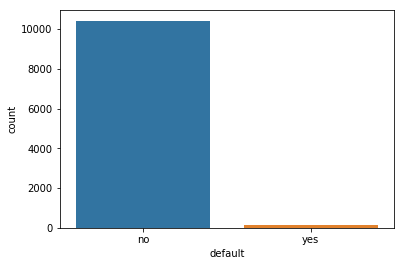

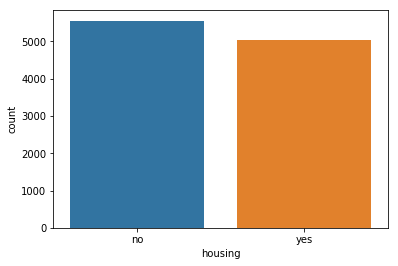

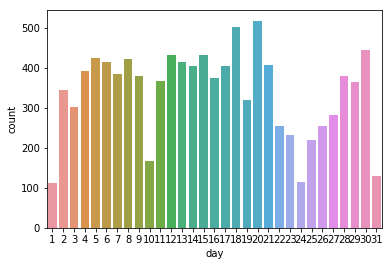

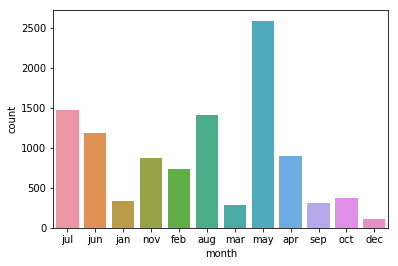

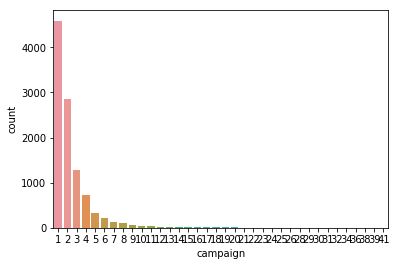

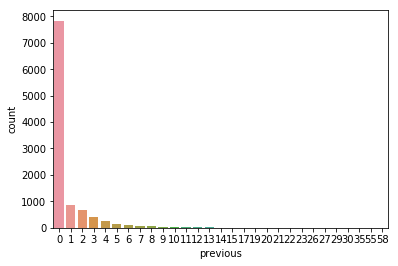

In [22]:
for col in discr_num_cols:
    sns.countplot(features[col])
    plt.show()

#### Continuous numeric features

In [23]:
contin_num_cols = ['age','balance','duration','pdays']

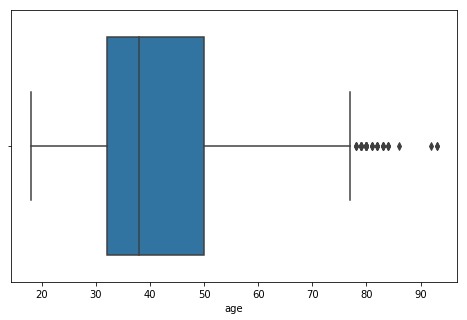

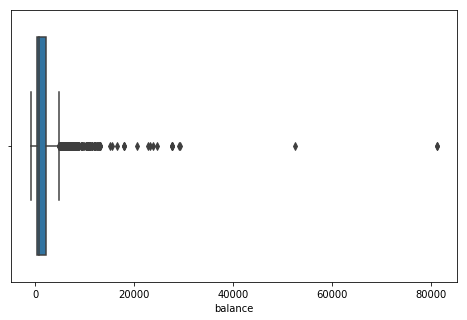

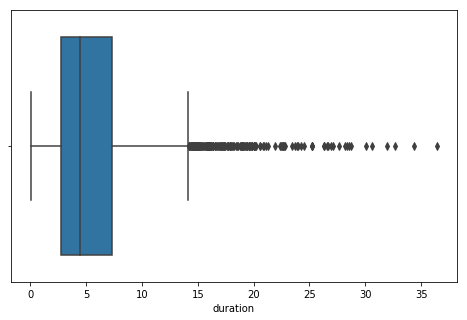

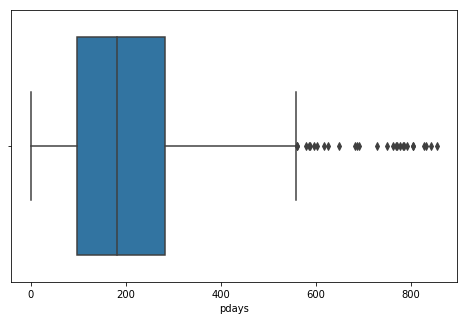

In [24]:
# CHECK OUTLIERS
for col in features[contin_num_cols]:
    plt.figure(figsize=(8,5))
    sns.boxplot(df[col])
    plt.show()

In [25]:
# age
q1 = np.percentile(df['age'], 25)
q3 = np.percentile(df['age'], 75)
iqr = q3 - q1
upper_wisker = q3 + (iqr * 1.5)
lower_wisker = q1 - (iqr * 1.5)
print('Upper wisker is {:.3f}'.format(upper_wisker))
print('Lower wisker is {:.3f}'.format(lower_wisker))

Upper wisker is 77.000
Lower wisker is 5.000


In [26]:
outliers = df[(df['age'] >= upper_wisker) | (df['age'] <= lower_wisker)]
outliers_num = len(outliers)
outliers_perc = outliers_num / len(df)
print('Number of outliers: {}'.format(outliers_num))
print('Percentage of outliers: {:.3f}'.format(outliers_perc))

Number of outliers: 52
Percentage of outliers: 0.019


In [27]:
outliers_rows = outliers.index
df = df.drop(index=outliers_rows, axis=0)
df = df.reset_index(drop=True)

In [28]:
# balance
q1 = np.percentile(df['balance'], 25)
q3 = np.percentile(df['balance'], 75)
iqr = q3 - q1
upper_wisker = q3 + (iqr * 1.5)

lower_wisker = q1 - (iqr * 1.5)
print('Upper wisker is {:.3f}'.format(upper_wisker))
print('Lower wisker is {:.3f}'.format(lower_wisker))

Upper wisker is 4774.875
Lower wisker is -2526.125


In [29]:
outliers = df[(df['balance'] >= upper_wisker) | (df['balance'] <= lower_wisker)]
outliers_num = len(outliers)
outliers_perc = outliers_num / len(df)
print('Number of outliers: {}'.format(outliers_num))
print('Percentage of outliers: {:.3f}'.format(outliers_perc))

Number of outliers: 224
Percentage of outliers: 0.083


In [30]:
outliers_rows = outliers.index
df = df.drop(index=outliers_rows, axis=0)
df = df.reset_index(drop=True)

In [31]:
# duration
q1 = np.percentile(df['duration'], 25)
q3 = np.percentile(df['duration'], 75)
iqr = q3 - q1
upper_wisker = q3 + (iqr * 1.5)
lower_wisker = q1 - (iqr * 1.5)
print('Upper wisker is {:.3f}'.format(upper_wisker))
print('Lower wisker is {:.3f}'.format(lower_wisker))

Upper wisker is 13.810
Lower wisker is -3.910


In [32]:
outliers = df[(df['duration'] >= upper_wisker) | (df['duration'] <= lower_wisker)]
outliers_num = len(outliers)
outliers_perc = outliers_num / len(df)
print('Number of outliers: {}'.format(outliers_num))
print('Percentage of outliers: {:.3f}'.format(outliers_perc))

Number of outliers: 150
Percentage of outliers: 0.061


In [33]:
outliers_rows = outliers.index
df = df.drop(index=outliers_rows, axis=0)
df = df.reset_index(drop=True)

In [34]:
# pdays
q1 = np.percentile(df['pdays'], 25)
q3 = np.percentile(df['pdays'], 75)
iqr = q3 - q1
upper_wisker = q3 + (iqr * 1.5)
lower_wisker = q1 - (iqr * 1.5)
print('Upper wisker is {:.3f}'.format(upper_wisker))
print('Lower wisker is {:.3f}'.format(lower_wisker))

Upper wisker is 565.500
Lower wisker is -182.500


In [35]:
outliers = df[(df['pdays'] >= upper_wisker) | (df['pdays'] <= lower_wisker)]
outliers_num = len(outliers)
outliers_perc = outliers_num / len(df)
print('Number of outliers: {}'.format(outliers_num))
print('Percentage of outliers: {:.3f}'.format(outliers_perc))

Number of outliers: 26
Percentage of outliers: 0.011


In [36]:
outliers_rows = outliers.index
df = df.drop(index=outliers_rows, axis=0)
df = df.reset_index(drop=True)

In [37]:
# check types
features[num_cols].dtypes

age         int64
balance     int64
day         int64
duration    int64
campaign    int64
pdays       int64
previous    int64
dtype: object

In [38]:
df['balance'] = df['balance'].astype('float64')

### Analysis of respondent 

In [39]:
num_cols = df.select_dtypes(include='number').columns
grouped_response = df[num_cols].groupby('response').mean()
grouped_response

,age,default,balance,housing,loan,day,month,duration,campaign,pdays,previous
response,,,,,,,,,,,
0,39.884967,0.011765,792.602614,0.750327,0.173856,13.925490,5.342484,3.333111,2.067974,235.329412,3.033987
1,41.517377,0.003279,1150.201967,0.327213,0.066230,14.601967,6.542295,5.596689,1.763934,183.782951,3.208525


In [40]:
# age 
bins = [0,30,40,50,60,70]
labels = ['20','30','40','50','60']
age_bins = pd.cut(df['age'], bins, labels=labels)
age_response = pd.crosstab(age_bins, df['response'])
age_response

response,0,1
age,,
20,120,320
30,326,535
40,194,282
50,109,237
60,12,111


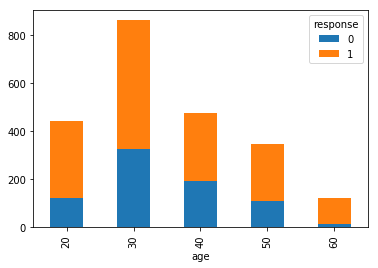

In [41]:
age_response.plot.bar(stacked=True)
plt.show()

In [42]:
#job
job_response = pd.crosstab(df['job'], df['response'])
job_response

response,0,1
job,,
admin.,94,216
blue-collar,180,150
entrepreneur,29,23
housemaid,15,28
management,144,407
others,0,12
retired,24,140
self-employed,23,49
services,84,100


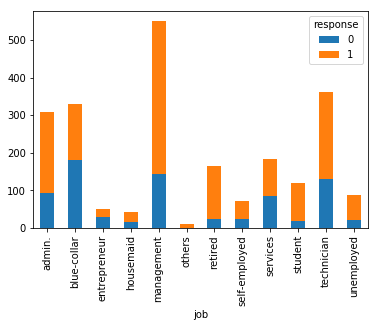

In [43]:
job_response.plot.bar(stacked=True)
plt.show()

In [44]:
# marital
marital_response = pd.crosstab(df['marital'], df['response'])
marital_response

response,0,1
marital,,
divorced,81,142
married,446,827
single,238,556


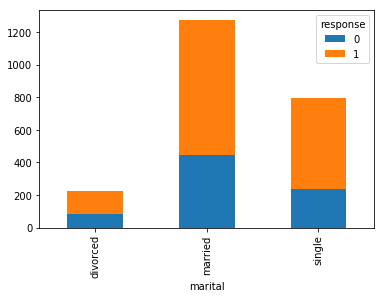

In [45]:
marital_response.plot.bar(stacked=True)
plt.show()

In [46]:
# education
education_response = pd.crosstab(df['education'], df['response'])
education_response

response,0,1
education,,
others,29,77
primary,98,116
secondary,427,711
tertiary,211,621


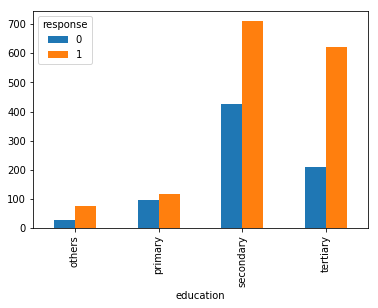

In [47]:
education_response.plot.bar()
plt.show()

In [48]:
# default
default_response = pd.crosstab(df['default'], df['response'])
default_response

response,0,1
default,,
0,756,1520
1,9,5


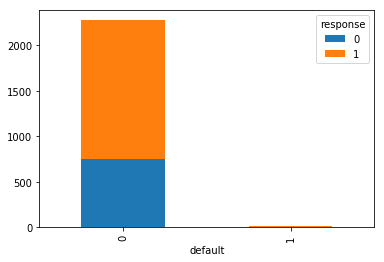

In [49]:
default_response.plot.bar(stacked=True)
plt.show()

In [50]:
# balance 
bins = [-1000,0,1000,2000,3000,4000]
labels = ['negative','low','1000','2000','3000']
balance_bins = pd.cut(df['balance'], bins, labels=labels)
balance_response = pd.crosstab(balance_bins, df['response'])
balance_response

response,0,1
balance,,
negative,110,112
low,430,791
1000,127,282
2000,68,194
3000,22,103


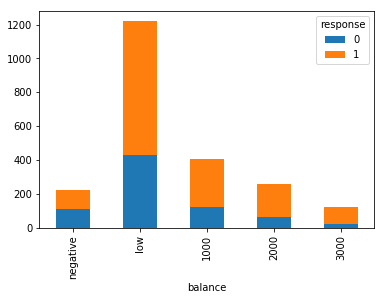

In [51]:
balance_response.plot.bar(stacked=True)
plt.show()

In [52]:
# housing
housing_response = pd.crosstab(df['housing'], df['response'])
housing_response

response,0,1
housing,,
0,191,1026
1,574,499


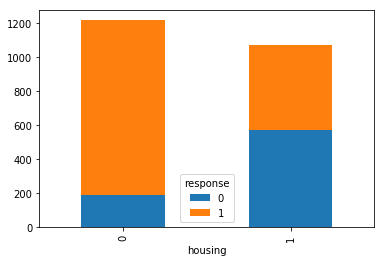

In [53]:
housing_response.plot.bar(stacked=True)
plt.show()

In [54]:
# loan
loan_response = pd.crosstab(df['loan'], df['response'])
loan_response

response,0,1
loan,,
0,632,1424
1,133,101


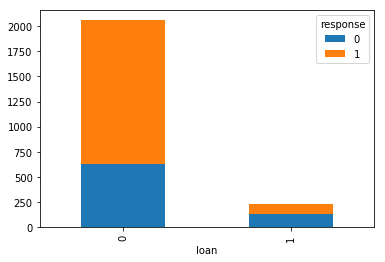

In [55]:
loan_response.plot.bar(stacked='True')
plt.show()

In [56]:
# day
day_response = pd.crosstab(df['day'], df['response'])
day_response.sort_values(by=1, ascending=False)

response,0,1
day,,
12,37,91
4,24,86
15,44,85
13,33,81
30,22,66
9,16,65
14,38,61
3,25,61
11,25,61


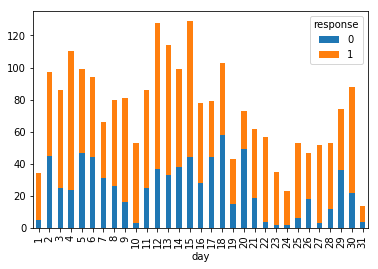

In [57]:
day_response.plot.bar(stacked=True)
plt.show()

In [58]:
# month
month_response = pd.crosstab(df['month'], df['response'])
month_response

response,0,1
month,,
1,53,50
2,118,147
3,6,78
4,111,140
5,271,219
6,19,130
7,12,109
8,33,206
9,16,129


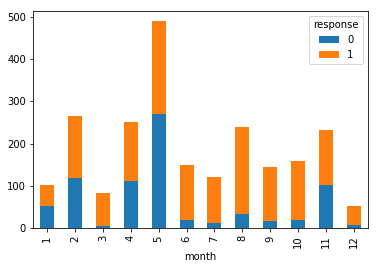

In [59]:
month_response.plot.bar(stacked=True)
plt.show()

In [60]:
# duration, in minutes
bins = [0,1,2,3,4,5,6,7,8,9,10,11]
labels = ['1','2','3','4','5','6','7','8','9','10','11']
duration_bins = pd.cut(df['duration'], bins, labels=labels)
duration_bins_response = pd.crosstab(duration_bins, df['response'])
duration_bins_response

response,0,1
duration,,
1,79,2
2,202,74
3,169,200
4,96,276
5,63,250
6,52,181
7,35,134
8,19,99
9,16,81


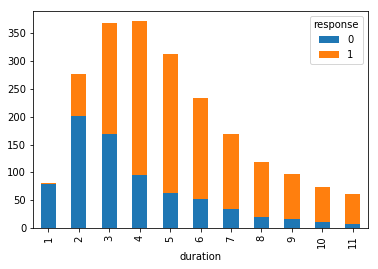

In [61]:
duration_bins_response.plot.bar(stacked=True)
plt.show()

In [62]:
# campaign
campaign_response = pd.crosstab(df['campaign'], df['response'])
campaign_response

response,0,1
campaign,,
1,351,840
2,233,409
3,85,168
4,36,57
5,27,25
6,15,17
7,11,3
8,3,4
9,3,1


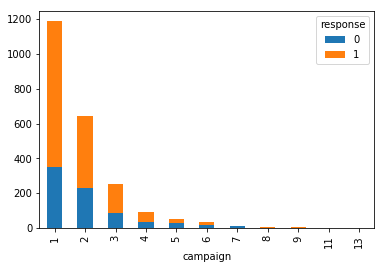

In [63]:
campaign_response.plot.bar(stacked=True)
plt.show()

In [64]:
# pdays
bins = [0,100,200,300,400,500,616]
labels = ['100','200','300','400','500','600']
pdays_bins = pd.cut(df['pdays'], bins, labels=labels)
pdays_bins_response = pd.crosstab(pdays_bins, df['response'])
pdays_bins_response

response,0,1
pdays,,
100,87,520
200,242,613
300,181,143
400,246,168
500,4,62
600,5,19


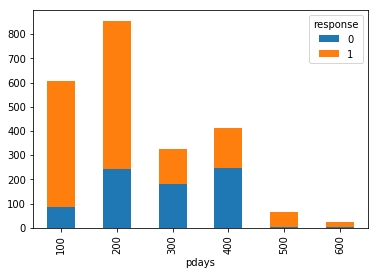

In [65]:
pdays_bins_response.plot.bar(stacked=True)
plt.show()

In [66]:
# previous
bins = [0,55,110,165,220,275]   
labels = ['55','110','165','220','275']
previous_bins = pd.cut(df['previous'], bins, labels=labels)
previous_response = pd.crosstab(previous_bins, df['response'])
previous_response

response,0,1
previous,,
55,765,1524
110,0,1


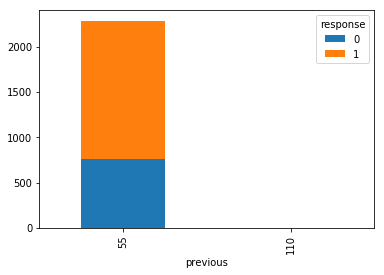

In [67]:
previous_response.plot.bar(stacked=True)
plt.show()

In [68]:
# poutcome
poutcome_response = pd.crosstab(df['poutcome'], df['response'])
poutcome_response

response,0,1
poutcome,,
failure,525,467
other,187,237
success,53,821


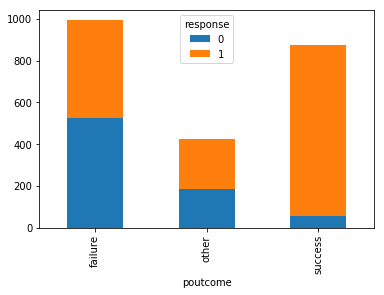

In [69]:
poutcome_response.plot.bar(stacked=True)
plt.show()

Respondent: <br>
    - age: 30 to 40 years old,
    - job: management,
    - marital: married,
    - education: secondary,
    - default: has credit in default?: No (0),
    - balance: low, up to 1000, 
    - housing: has housing loan?: No (0), 
    - loan: has personal loan?: No(0),
    - day: 12, 4, 15, 13: first two weeks,
    - month: August (8), 
    - duration: last contact duration, in minutes: 4-5, 
    - campaign:  number of contacts performed during this campaign and for this client: 1, 
    - pdays: number of days passed by after the client was last contacted from a previous campaign: < 200,
    - previous: number of contacts performed before this campaign and for this client: up to 55. 
    - poutcome: outcome of the previous marketing campaign: success (1)

### One hot encode for categorical variables

In [70]:
cat_cols = df.select_dtypes(include='object').columns
cat_cols

Index(['job', 'marital', 'education', 'poutcome'], dtype='object')

In [71]:
df = pd.get_dummies(df, columns= cat_cols, drop_first=True)
df.head(3)

,age,default,balance,housing,loan,day,month,duration,campaign,pdays,...,job_student,job_technician,job_unemployed,marital_married,marital_single,education_primary,education_secondary,education_tertiary,poutcome_other,poutcome_success
0,28,0,527.0,1,0,29,1,2.68,2,265,...,0,1,0,0,1,0,1,0,0,0
1,37,0,600.0,1,0,17,11,1.93,2,196,...,0,0,0,0,1,0,0,1,0,0
2,46,0,3455.0,1,0,20,11,2.00,4,190,...,0,1,0,0,0,0,1,0,0,0


### Standardization

In [72]:
to_scale_cols = df.drop(columns=['response']).columns
scaler = StandardScaler().fit_transform(df[to_scale_cols])
scaled_df = pd.DataFrame(data=scaler, columns=to_scale_cols )
scaled_df.head()

/home/ricardo/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/ricardo/.local/lib/python3.5/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,age,default,balance,housing,loan,day,month,duration,campaign,pdays,...,job_student,job_technician,job_unemployed,marital_married,marital_single,education_primary,education_secondary,education_tertiary,poutcome_other,poutcome_success
0,-1.086604,-0.078429,-0.446695,1.064990,-0.337362,1.754355,-1.673080,-0.718775,0.105039,0.578392,...,-0.236191,2.304027,-0.199909,-1.118803,1.372637,-0.321065,1.006132,-0.755410,-0.47668,-0.785641
1,-0.332719,-0.078429,-0.381962,1.064990,-0.337362,0.314788,1.580999,-0.968290,0.105039,-0.045212,...,-0.236191,-0.434023,-0.199909,-1.118803,1.372637,-0.321065,-0.993905,1.323784,-0.47668,-0.785641
2,0.421166,-0.078429,2.149721,1.064990,-0.337362,0.674680,1.580999,-0.945002,1.666990,-0.099439,...,-0.236191,2.304027,-0.199909,-1.118803,-0.728525,-0.321065,1.006132,-0.755410,-0.47668,-0.785641
3,-0.332719,-0.078429,-0.598330,-0.938976,-0.337362,-0.644924,-1.347672,-1.427397,0.105039,0.135542,...,-0.236191,-0.434023,5.002272,0.893812,-0.728525,-0.321065,1.006132,-0.755410,-0.47668,-0.785641
4,0.086106,-0.078429,-0.287080,-0.938976,-0.337362,-1.604636,-0.046040,-0.319551,-0.675936,1.328524,...,-0.236191,-0.434023,-0.199909,0.893812,-0.728525,-0.321065,1.006132,-0.755410,-0.47668,1.272846


### MODELS

In [73]:
# features and target variables
X = scaled_df
y = df['response']

In [74]:
# train and test sets
X_train, X_test,y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=4)

### Compare several models, default parameters

Cross validation is a way to predict the fit of a model to a hypothetical set of test data.

In [75]:
models = []
models.append(('Logistic Regression', LogisticRegression(solver='lbfgs', max_iter=3000)))
models.append(('Decision Tree Classifier', DecisionTreeClassifier()))
models.append(('K-Nearest Neighbors Classifier', KNeighborsClassifier()))

In [76]:
results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=10, random_state=4)    
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='precision')    
    # precision is a better metric in this case than accuracy
    results.append(cv_results)
    names.append(name)
    print('Model: {}, precision: {:.3f}'.format(name, cv_results.mean()))

Model: Logistic Regression, precision: 0.861
Model: Decision Tree Classifier, precision: 0.857
Model: K-Nearest Neighbors Classifier, precision: 0.837


Cross validation gives a better score for Logistic Regression. However all models are deployed below with custumized parameters.

### Features selection: PCA

In [77]:
pca = PCA(n_components=0.80).fit(X_train) 
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print('Number of components: {}'.format(pca.n_components_))

Number of components: 18


### Logistic Regression 

#### all features

In [78]:
log_reg_all = LogisticRegression(solver='lbfgs', max_iter=3000,).fit(X_train, y_train)

In [79]:
# coefficients, absolute values
coefs_abs = np.round(np.abs(log_reg_all.coef_), decimals=2)
coefs_abs

array([[0.  , 0.04, 0.25, 0.71, 0.19, 0.03, 0.19, 1.11, 0.22, 0.  , 0.13,
        0.26, 0.24, 0.05, 0.12, 0.28, 0.06, 0.14, 0.18, 0.01, 0.14, 0.1 ,
        0.02, 0.03, 0.28, 0.24, 0.01, 0.1 , 1.14]])

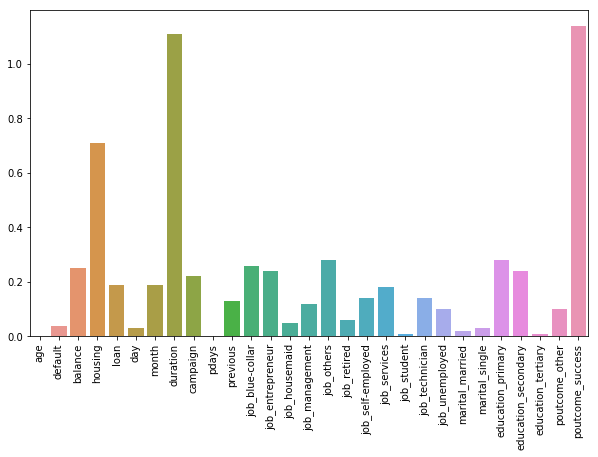

In [80]:
plt.figure(figsize=(10,6))
sns.barplot(X_train.columns, coefs_abs[0])
plt.xticks(rotation=90)
plt.show()

More relevant features: poutcome_success, education_primary and housing.

In [81]:
# prediction
y_pred = log_reg_all.predict(X_test)

In [82]:
# precision
score_log_reg_all = precision_score(y_test, y_pred)
print('Logistic regression with all features gives a precision of {:.3f}'.format(score_log_reg_all))

Logistic regression with all features gives a precision of 0.862


In [83]:
# confusion matrix
confus_matrix = confusion_matrix(y_test, y_pred)
confus_matrix

array([[118,  42],
       [ 35, 263]])

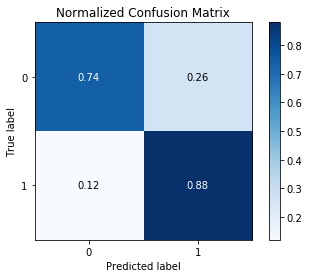

In [84]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()

#### 3 features with highest coeficients

In [86]:
coef_3 = ['poutcome_success', 'education_primary', 'housing']
X_train_coef_3 = X_train[coef_3]
X_test_coef_3 = X_test[coef_3]
log_reg_coef_3 = LogisticRegression(solver='lbfgs', max_iter=3000,).fit(X_train_coef_3, y_train)
y_pred = log_reg_coef_3.predict(X_test_coef_3)

In [87]:
# precision
score_log_reg_coef_3 = precision_score(y_test, y_pred)
print('Logistic regression with highest 3 coeficients gives a precision of {:.3f}'.format(score_log_reg_coef_3))

Logistic regression with highest 3 coeficients gives a precision of 0.840


In [88]:
# confusion matrix
confus_matrix = confusion_matrix(y_test, y_pred)
confus_matrix

array([[116,  44],
       [ 67, 231]])

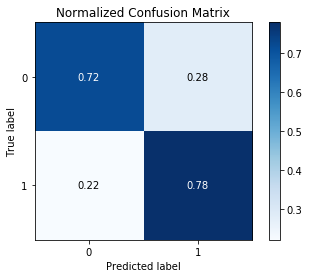

In [89]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()

#### 3 features rfe selected 

In [90]:
# RFE (Recursive feature elimination)
estimator = LogisticRegression(solver='lbfgs', max_iter=3000,).fit(X_train, y_train)
rfe = RFE(estimator, n_features_to_select=3).fit(X_train, y_train)
feat_sel = rfe.support_

In [91]:
rfe.support_

array([False, False, False,  True, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True])

In [92]:
cols = X_train.columns
zipped = zip(feat_sel, cols)
true = []
for f,c in zipped:
    if f==True:
        true.append(c)

In [93]:
rfe_3= true
rfe_3

['housing', 'duration', 'poutcome_success']

In [94]:
# model
X_train_rfe_3 = X_train[rfe_3]
X_test_rfe_3 = X_test[rfe_3]
log_reg_rfe_3 = LogisticRegression(solver='lbfgs', max_iter=3000,).fit(X_train_rfe_3, y_train)
y_pred = log_reg_rfe_3.predict(X_test_rfe_3)

In [95]:
# precision
score_log_reg_rfe_3 = precision_score(y_test, y_pred)
print('Logistic regression with 3 rfe features gives a precision of {:.3f}'.format(score_log_reg_rfe_3))

Logistic regression with 3 rfe features gives a precision of 0.860


In [96]:
# confusion matrix
confus_matrix = confusion_matrix(y_test, y_pred)
confus_matrix

array([[117,  43],
       [ 33, 265]])

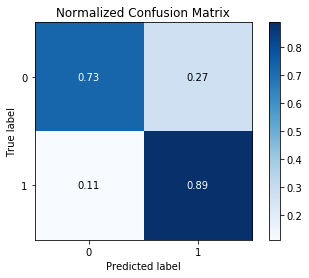

In [97]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()

#### features pca selected

In [98]:
# model
log_reg_pca_20 = LogisticRegression(solver='lbfgs', max_iter=3000,).fit(X_train_pca, y_train)
y_pred = log_reg_pca_20.predict(X_test_pca)

In [99]:
X_train_pca.shape

(1832, 18)

In [100]:
# precision
score_log_reg_pca_20 = precision_score(y_test, y_pred)
print('Logistic regression with 3 pca features gives a precision of {:.3f}'.format(score_log_reg_pca_20))

Logistic regression with 3 pca features gives a precision of 0.857


In [101]:
# confusion matrix
confus_matrix = confusion_matrix(y_test, y_pred)
confus_matrix

array([[117,  43],
       [ 40, 258]])

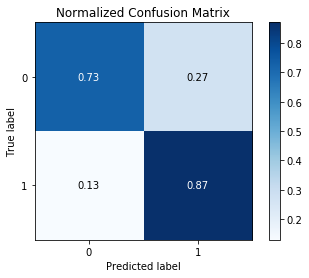

In [102]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()

#### Assumptions

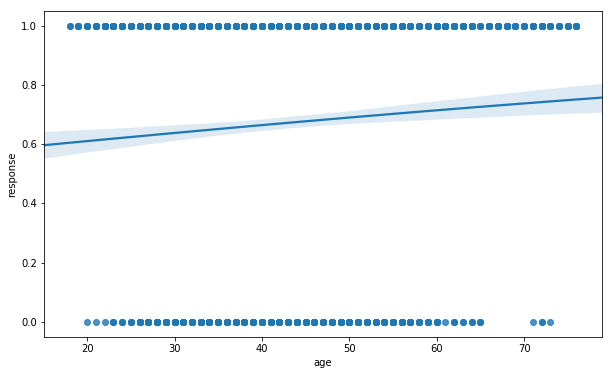

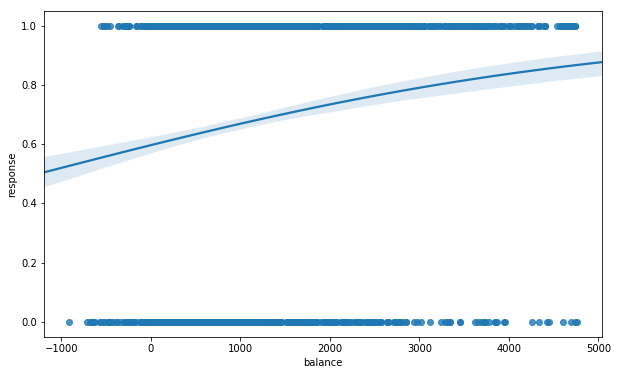

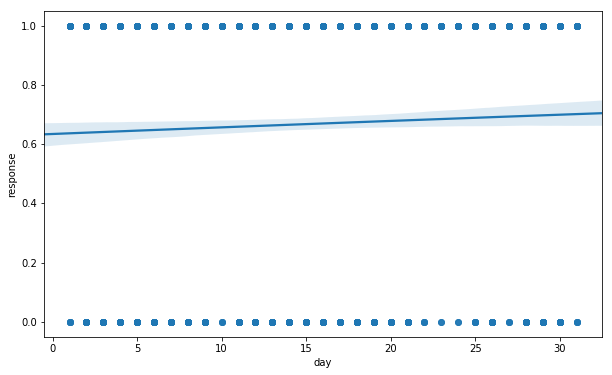

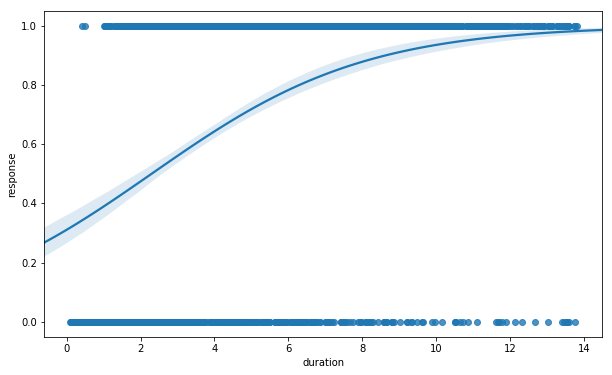

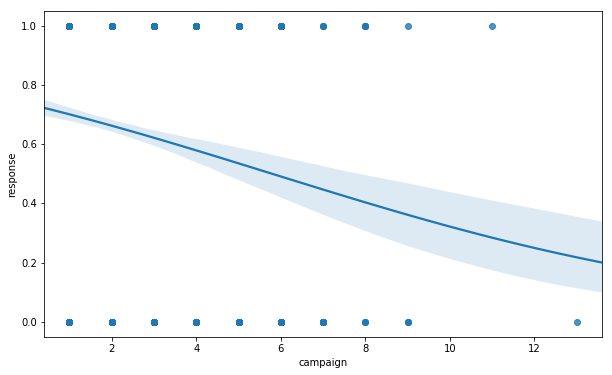

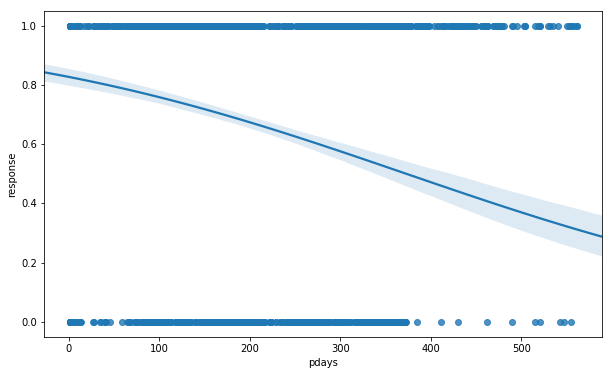

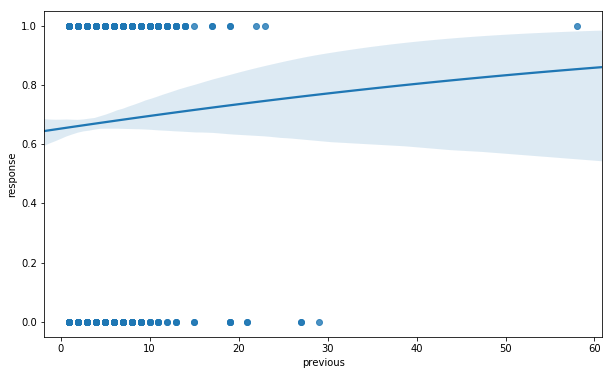

In [103]:
# continuous independent features linearly related to the log odds
cont_cols = features.select_dtypes(include='number').columns
for col in cont_cols:
    plt.figure(figsize=(10,6))
    sns.regplot(x=df[col], y='response', data=df, logistic=True)
    plt.show()

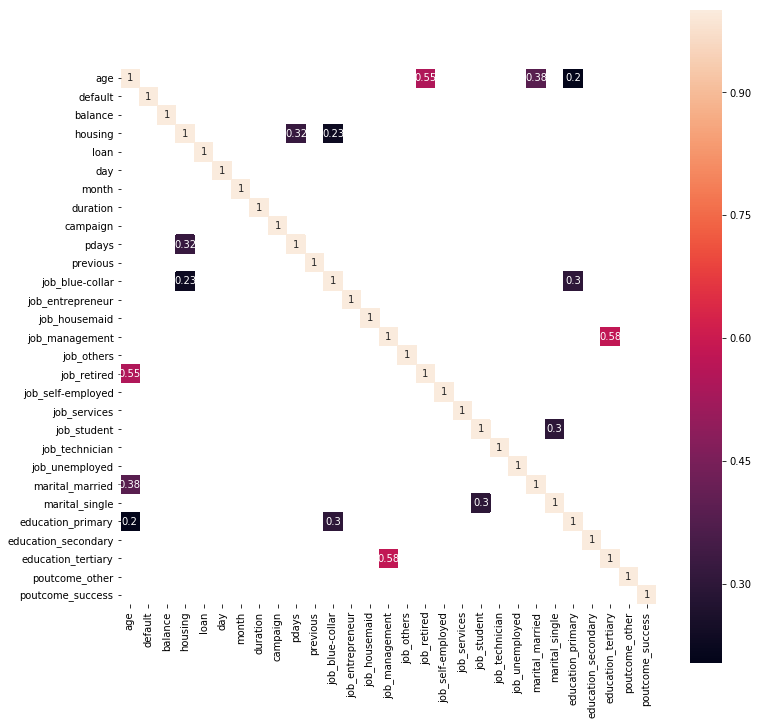

In [104]:
# absence of multicollinearity among the independent variables
corr_matrix = df.drop(columns='response', axis=1).corr()
plt.figure(figsize=(12,12))
sns.heatmap(corr_matrix[corr_matrix > 0.2], square=True, annot=True)
plt.show()

job_management and education_tertiary have a moderate r value (0.6), rest of the r values are lower.

### Decission Tree Classification

In [105]:
# search for best hyperparameters
tree_clf = DecisionTreeClassifier(random_state=4)
params = {'max_depth': np.arange(1,21,3), 'min_samples_leaf': np.arange(1,10,2)}
gsCV = GridSearchCV(estimator=tree_clf, param_grid=params, cv=3).fit(X_train, y_train)

In [106]:
# best model
best_tree_clf = gsCV.best_estimator_
print('Best parameters: {}'.format(gsCV.best_params_))
print('Score of the best model: {:.3f}'.format(gsCV.best_score_))

Best parameters: {'max_depth': 7, 'min_samples_leaf': 7}
Score of the best model: 0.830


In [107]:
# feature importances
importances = best_tree_clf.feature_importances_
importances

array([0.01305557, 0.        , 0.02635983, 0.12899619, 0.        ,
       0.04091064, 0.07156252, 0.30455457, 0.00789273, 0.05073557,
       0.01480665, 0.        , 0.00339623, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00047194, 0.        , 0.        ,
       0.        , 0.01822411, 0.        , 0.31903344])

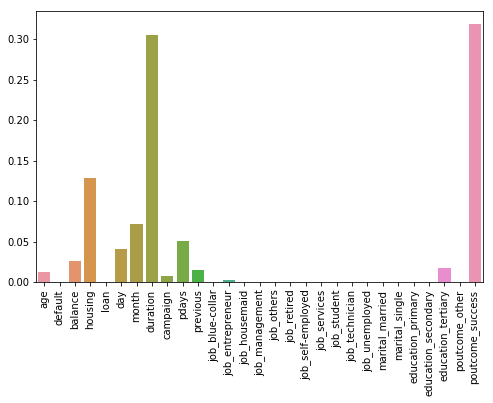

In [108]:
plt.figure(figsize=(8,5))
sns.barplot(x=X_train.columns, y=importances)
plt.xticks(rotation=90)
plt.show()

In [109]:
# prediction
y_pred = best_tree_clf.predict(X_test)

In [110]:
# precision
score_tree_clf = precision_score(y_test, y_pred)

In [111]:
# confusion matrix
confus_matrix = confusion_matrix(y_test, y_pred)
confus_matrix

array([[120,  40],
       [ 36, 262]])

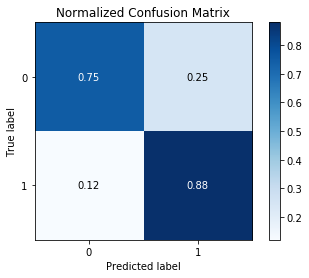

In [112]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()

In [113]:
print('Precision of the model is {0:.3f}'.format(score_tree_clf))

Precision of the model is 0.868


The model predicts well the true negatives, but only predicts well the true positives in 50% of cases.

### Random Forest Classifier

In [114]:
# search for best hyperparameters
rf_clf = RandomForestClassifier(n_estimators=100, random_state=4)
params = {'max_depth': np.arange(1,21,3), 'min_samples_leaf': np.arange(1,10,2)}
gsCV = GridSearchCV(estimator=rf_clf, param_grid=params, cv=3).fit(X_train, y_train)

In [115]:
# best model
best_rf_clf = gsCV.best_estimator_
print('Best parameters: {}'.format(gsCV.best_params_))
print('Score of the best model: {:.3f}'.format(gsCV.best_score_))

Best parameters: {'max_depth': 16, 'min_samples_leaf': 1}
Score of the best model: 0.865


In [116]:
# feature importances
importances = best_rf_clf.feature_importances_
importances

array([0.0599949 , 0.00085677, 0.07094768, 0.06969237, 0.01301726,
       0.06878606, 0.08732016, 0.22255421, 0.02882038, 0.10982617,
       0.03267997, 0.01520072, 0.00522898, 0.00207942, 0.00921926,
       0.00033235, 0.00462899, 0.00257074, 0.00642332, 0.00421414,
       0.00844953, 0.00325585, 0.01043227, 0.01030754, 0.00469043,
       0.009219  , 0.01080299, 0.01104292, 0.11740563])

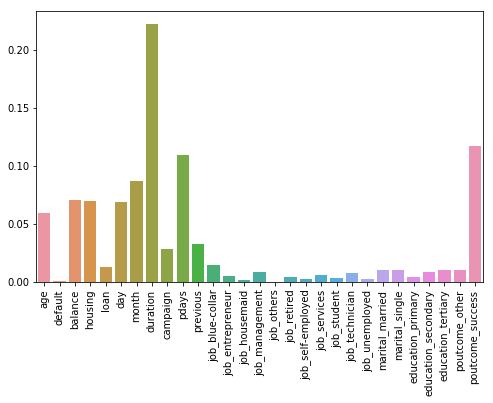

In [117]:
plt.figure(figsize=(8,5))
sns.barplot(x=X_train.columns, y=importances)
plt.xticks(rotation=90)
plt.show()

In [118]:
# prediction
y_pred = best_rf_clf.predict(X_test)

In [119]:
# precision
score_rf_clf = precision_score(y_test, y_pred)

In [120]:
# confusion matrix
confus_matrix = confusion_matrix(y_test, y_pred)
confus_matrix

array([[118,  42],
       [ 20, 278]])

### K-nearest neighbors

In [121]:
# search for best hyperparameters using GridSeachCV and pca 
knn_clf = KNeighborsClassifier()
params = {'n_neighbors': np.arange(5,23,2)}
gsCV = GridSearchCV(estimator=knn_clf, param_grid=params, cv=3).fit(X_train_pca, y_train)

In [122]:
# best model
best_knn_clf = gsCV.best_estimator_
print('Best parameters: {}'.format(gsCV.best_params_))
print('Score of the best model: {:.3f}'.format(gsCV.best_score_))

Best parameters: {'n_neighbors': 17}
Score of the best model: 0.793


In [123]:
# prediction
y_pred = best_knn_clf.predict(X_test_pca)

In [124]:
# precision
score_knn_clf = precision_score(y_test, y_pred)

In [125]:
# confusion matrix
confus_matrix = confusion_matrix(y_test, y_pred)
confus_matrix

array([[ 99,  61],
       [ 42, 256]])

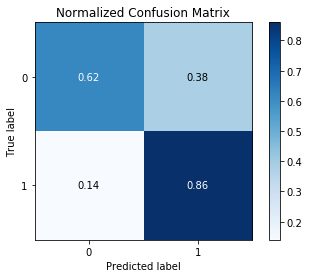

In [126]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()

### Conclusion

In [127]:
print('Precision of Logistic Regression model all features: {:.3f}'.format(score_log_reg_all))
print('Precision of Logistic regression with highest 3 coeficients features: {:.3f}'.format(score_log_reg_coef_3))
print('Precision of Logistic regression with 3 rfe features: {:.3f}'.format(score_log_reg_rfe_3))
print('Precision of Logistic regression with 3 pca features: {:.3f}'.format(score_log_reg_rfe_3))
print('Precision of Decission Tree Classifier model: {:.3f}'.format(score_tree_clf))
print('Precision of Random Forest Classifier model: {:.3f}'.format(score_rf_clf))
print('Precision of K-Nearest Neighbors Classifier model: {:.3f}'.format(score_knn_clf))

Precision of Logistic Regression model all features: 0.862
Precision of Logistic regression with highest 3 coeficients features: 0.840
Precision of Logistic regression with 3 rfe features: 0.860
Precision of Logistic regression with 3 pca features: 0.860
Precision of Decission Tree Classifier model: 0.868
Precision of Random Forest Classifier model: 0.869
Precision of K-Nearest Neighbors Classifier model: 0.808


Models that offer the greatest precision are Random Forest Classifier and Decission Tree Classifier.

According to previous analysis, a target respondent profile can be established. The most responsive customers possess these features:
- age: 30 to 40 years old,
- job: management,
- marital: married,
- education: secondary,
- default: has credit in default?: No (0),
- balance: low, up to 1000, 
- housing: has housing loan?: No (0), 
- loan: has personal loan?: No(0),
- day: 12, 4, 15, 13: first two weeks,
- month: August (8), 
- duration: last contact duration, in minutes: 4-5, 
- campaign:  number of contacts performed during this campaign and for this client: 1, 
- pdays: number of days passed by after the client was last contacted from a previous campaign: < 200,
- previous: number of contacts performed before this campaign and for this client: up to 55. 
- poutcome: outcome of the previous marketing campaign: success (1)